<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/Model_2_Devon_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install h5netcdf zarr xarray[complete] --quiet

     |████████████████████████████████| 153 kB 7.7 MB/s 
     |████████████████████████████████| 6.2 MB 29.1 MB/s 
     |████████████████████████████████| 2.3 MB 65.0 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 19.3 MB 69.9 MB/s 
     |████████████████████████████████| 140 kB 80.4 MB/s 
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 837 kB 55.5 MB/s 
     |████████████████████████████████| 830 kB 62.4 MB/s 
     |████████████████████████████████| 822 kB 71.1 MB/s 
     |████████████████████████████████| 802 kB 82.1 MB/s 
     |████████████████████████████████| 802 kB 65.1 MB/s 
     |████████████████████████████████| 793 kB 49.7 MB/s 
     |████████████████████████████████| 793 kB 58.0 MB/s 
     |████████████████████████████████| 791 kB 83.3 MB/s 
     |████████████████████████████████| 786 kB 78.3 MB/s 
     |████████████████████████████████| 779 kB 60.4 MB/s 
     |████████████

In [2]:
import numpy as np
import datetime
import pandas as pd
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Loading satellite images and timestamps

In [54]:
train_sat = np.load("/content/drive/My Drive/Colab Notebooks/dissertation/cropping_satellite_data/both_years_128_training.npy")
train_sat_times = np.load("/content/drive/My Drive/Colab Notebooks/dissertation/cropping_satellite_data/both_years_128_train_times.npy")

test_sat = np.load("/content/drive/My Drive/Colab Notebooks/dissertation/cropping_satellite_data/both_years_128_validation.npy")
test_sat_times = np.load("/content/drive/My Drive/Colab Notebooks/dissertation/cropping_satellite_data/both_years_128_test_times.npy")

In [55]:
print(train_sat.shape)
print(train_sat_times.shape)
print(test_sat.shape)
print(test_sat_times.shape)

(17065, 128, 128)
(17065,)
(3246, 128, 128)
(3246,)


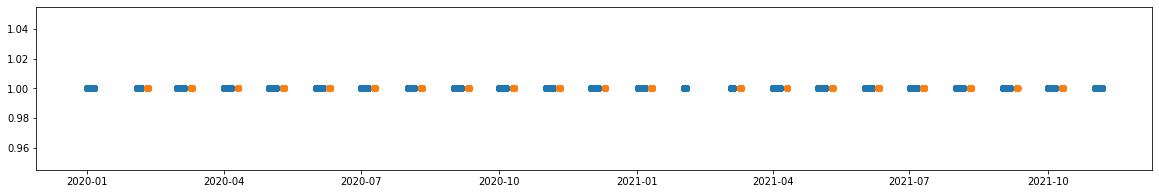

In [56]:
fig = plt.figure(figsize=(20,3))

plt.scatter(train_sat_times, np.ones(len(train_sat_times)))
plt.scatter(test_sat_times, np.ones(len(test_sat_times)));

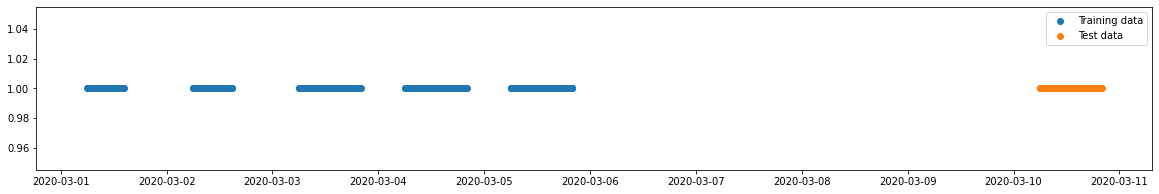

In [57]:
range_train_sat_times = [] 

for timestamp in train_sat_times:
  if (pd.Timestamp(timestamp) > pd.Timestamp(2020,3,1)) & (pd.Timestamp(timestamp) < pd.Timestamp(2020,3,30)):
    range_train_sat_times.append(timestamp) 


range_test_sat_times = [] 

for timestamp in test_sat_times:
  if (pd.Timestamp(timestamp) > pd.Timestamp(2020,3,1)) & (pd.Timestamp(timestamp) < pd.Timestamp(2020,3,30)):
    range_test_sat_times.append(timestamp)

fig = plt.figure(figsize=(20,3))

plt.scatter(range_train_sat_times, np.ones(len(range_train_sat_times)), label='Training data')
plt.scatter(range_test_sat_times, np.ones(len(range_test_sat_times)), label='Test data')
plt.legend();


# Loading PV readings

In [58]:
pv_power = xr.open_dataset("/content/drive/My Drive/Colab Notebooks/dissertation/uk_pv/pv.netcdf", engine="h5netcdf")

In [59]:
devon_ss_ids = [5444, 6835, 7159, 7245, 7276, 7763] # we previously found these sites in Devon with PV readings

In [60]:
dataframes = []
for ss_id in devon_ss_ids:
    dataframes.append(pv_power['{}'.format(ss_id)].to_dataframe())

pv_df = pd.concat(dataframes, axis=1)
pv_df['Mean'] = pv_df.mean(axis=1)

#cropping to match 6am to 8pm span, same as satellite
pv_df = pv_df[(pv_df.index.hour > 5) & (pv_df.index.hour < 20)]

In [61]:
pv_df.index

DatetimeIndex(['2018-01-01 06:05:00', '2018-01-01 06:10:00',
               '2018-01-01 06:15:00', '2018-01-01 06:20:00',
               '2018-01-01 06:25:00', '2018-01-01 06:30:00',
               '2018-01-01 06:35:00', '2018-01-01 06:40:00',
               '2018-01-01 06:45:00', '2018-01-01 06:50:00',
               ...
               '2021-10-27 19:10:00', '2021-10-27 19:15:00',
               '2021-10-27 19:20:00', '2021-10-27 19:25:00',
               '2021-10-27 19:30:00', '2021-10-27 19:35:00',
               '2021-10-27 19:40:00', '2021-10-27 19:45:00',
               '2021-10-27 19:50:00', '2021-10-27 19:55:00'],
              dtype='datetime64[ns]', name='datetime', length=233458, freq=None)

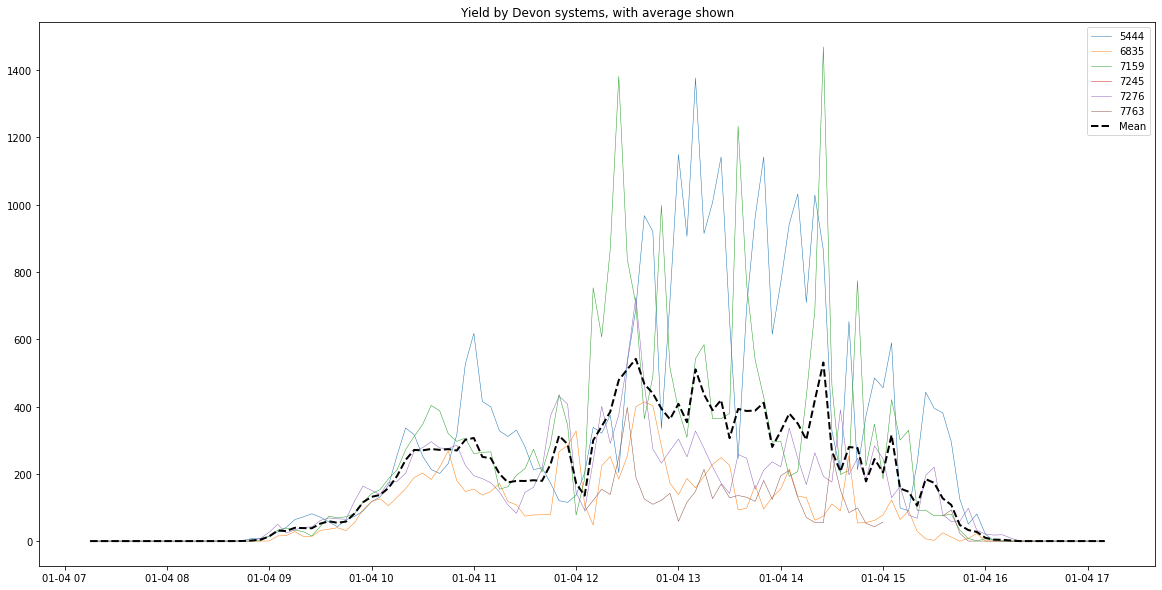

In [62]:
fig = plt.figure(figsize=(20,10))

pv_df_cropped = pv_df[500:500+120]

for i in range(pv_df_cropped.shape[1]-1):

    plt.plot(pv_df_cropped.iloc[:,i], label=pv_df_cropped.columns[i], linewidth=0.5)
    
plt.plot(pv_df_cropped.iloc[:,-1], "--", label='Mean', linewidth=2, color='black')

plt.legend()
plt.title('Yield by Devon systems, with average shown');

# Thought - maybe I should divide each of the PV systems by their total capacity, since this is quite skewed by the larger ones

# Get PV readings for satellite frames

In [63]:
# pv readings
print(pv_df.shape)

# train sat images
print(train_sat.shape)

# train sat timestamps
print(train_sat_times.shape)

# test sat images
print(test_sat.shape)

# test sat timestamps
print(test_sat_times.shape)


(233458, 7)
(17065, 128, 128)
(17065,)
(3246, 128, 128)
(3246,)


In [64]:
train_pv_readings = pd.DataFrame()

In [65]:
len(train_sat_times)

17065

In [66]:
train_pv_readings = []

for time in train_sat_times:
  try:
    reading = pv_df.Mean[pv_df.index == time][0]
    train_pv_readings.append(reading)

  except IndexError:
    train_pv_readings.append(0)
  
train_pv = np.asarray(train_pv_readings, dtype=object).astype('float32')

len(train_pv)

17065

In [67]:
test_pv_readings = []

counter = 0
for time in test_sat_times:
  try:
    reading = pv_df.Mean[pv_df.index ==time][0]
    test_pv_readings.append(reading)
  except IndexError:
    test_pv_readings.append(0)
    counter += 1

test_pv = np.asarray(test_pv_readings, dtype=object).astype('float32')

print(len(test_pv))
print(counter) # ok, some missing values but not very many, also will drop these later

3246
19


# Normalise the inputs

In [68]:
# train sat images
print(train_sat.shape)

# train sat timestamps
print(train_sat_times.shape)

# train pv
print(train_pv.shape)

# test sat images
print(test_sat.shape)

# test sat timestamps
print(test_sat_times.shape)

# test pv
print(test_pv.shape)

(17065, 128, 128)
(17065,)
(17065,)
(3246, 128, 128)
(3246,)
(3246,)


Deleting all the zero values

In [69]:
test_positions = []

for i in range(test_pv.shape[0]):
  if test_pv[i] < 0.001:
    test_positions.append(i)

test_pv = np.delete(test_pv, test_positions, axis=0)
test_sat = np.delete(test_sat, test_positions, axis=0)
test_sat_times = np.delete(test_sat_times, test_positions, axis=0)



In [70]:
train_positions = []

for i in range(train_pv.shape[0]):
  if train_pv[i] < 0.001:
    train_positions.append(i)

train_pv = np.delete(train_pv, train_positions, axis=0)
train_sat = np.delete(train_sat, train_positions, axis=0)
train_sat_times = np.delete(train_sat_times, train_positions, axis=0)

In [71]:
# train sat images
print(train_sat.shape)

# train sat timestamps
print(train_sat_times.shape)

# train pv
print(train_pv.shape)

# test sat images
print(test_sat.shape)

# test sat timestamps
print(test_sat_times.shape)

# test pv
print(test_pv.shape)

(13769, 128, 128)
(13769,)
(13769,)
(2753, 128, 128)
(2753,)
(2753,)


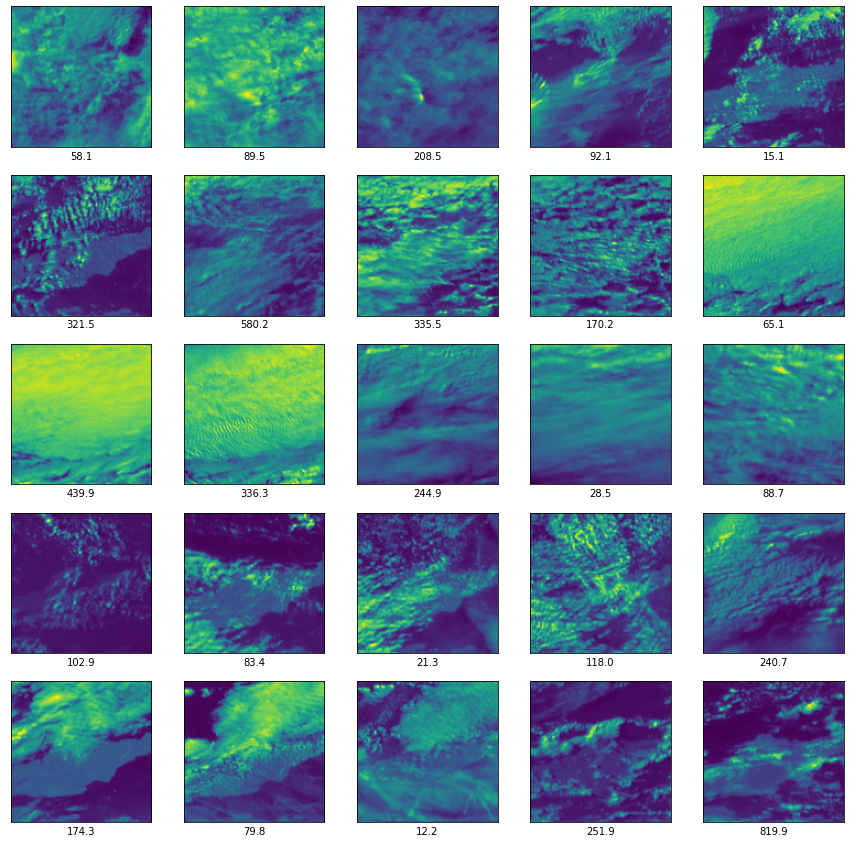

In [72]:
def print_prepared_grid(n):

    plt.figure(figsize=(15,15))
    for i in range(0,25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_sat[i*30+n])
        plt.xlabel(round(train_pv[i*20+n],1))
    plt.show()

X = train_sat
y = train_pv

print_prepared_grid(100)

In [84]:
train_sat_input = train_sat / 255
test_sat_input = test_sat / 255

max = np.max(train_pv)
train_pv_input = train_pv / (max + 1)
test_pv_input = test_pv / (max + 1)

# train sat images
print(train_sat.shape)

# train sat timestamps
print(train_sat_times.shape)

# train pv
print(train_pv.shape)

# test sat images
print(test_sat.shape)

# test sat timestamps
print(test_sat_times.shape)

# test pv
print(test_pv.shape)

(13769, 128, 128)
(13769,)
(13769,)
(2753, 128, 128)
(2753,)
(2753,)


In [74]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


In [85]:
train_sat

array([[[53, 52, 53, ..., 44, 45, 47],
        [59, 60, 59, ..., 49, 49, 47],
        [63, 63, 66, ..., 48, 52, 51],
        ...,
        [51, 51, 52, ..., 45, 44, 44],
        [51, 52, 51, ..., 45, 45, 44],
        [52, 51, 51, ..., 42, 42, 44]],

       [[67, 69, 74, ..., 51, 56, 60],
        [73, 71, 73, ..., 56, 59, 64],
        [70, 73, 76, ..., 55, 59, 62],
        ...,
        [56, 56, 56, ..., 49, 49, 48],
        [56, 58, 53, ..., 48, 48, 48],
        [56, 55, 55, ..., 48, 47, 49]],

       [[77, 82, 82, ..., 60, 63, 63],
        [80, 85, 84, ..., 67, 69, 63],
        [82, 84, 87, ..., 66, 67, 66],
        ...,
        [62, 62, 62, ..., 56, 56, 55],
        [60, 63, 62, ..., 58, 56, 53],
        [60, 60, 62, ..., 52, 55, 55]],

       ...,

       [[28, 27, 25, ..., 25, 24, 25],
        [24, 24, 28, ..., 24, 25, 24],
        [24, 22, 31, ..., 24, 24, 24],
        ...,
        [36, 31, 28, ..., 34, 30, 27],
        [42, 43, 39, ..., 34, 33, 31],
        [37, 48, 48, ..., 37, 42

In [97]:


model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [98]:

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

# Changed from 10 epochs down to 5

history = model.fit(train_sat_input, train_pv_input, epochs=5, 
                    validation_data=(test_sat_input, test_pv_input))

                    

Epoch 1/5
431/431 [==============================] - 42s 97ms/step - loss: 0.0232 - accuracy: 0.0000e+00 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 2/5
431/431 [==============================] - 42s 97ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0137 - val_accuracy: 0.0000e+00
Epoch 3/5
431/431 [==============================] - 42s 97ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 4/5
431/431 [==============================] - 42s 97ms/step - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0104 - val_accuracy: 0.0000e+00
Epoch 5/5
431/431 [==============================] - 42s 96ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0128 - val_accuracy: 0.0000e+00


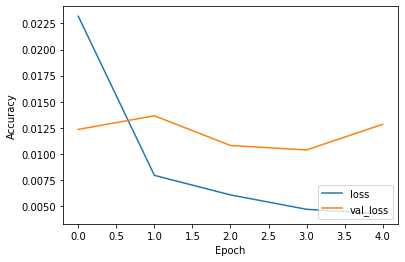

In [100]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right');


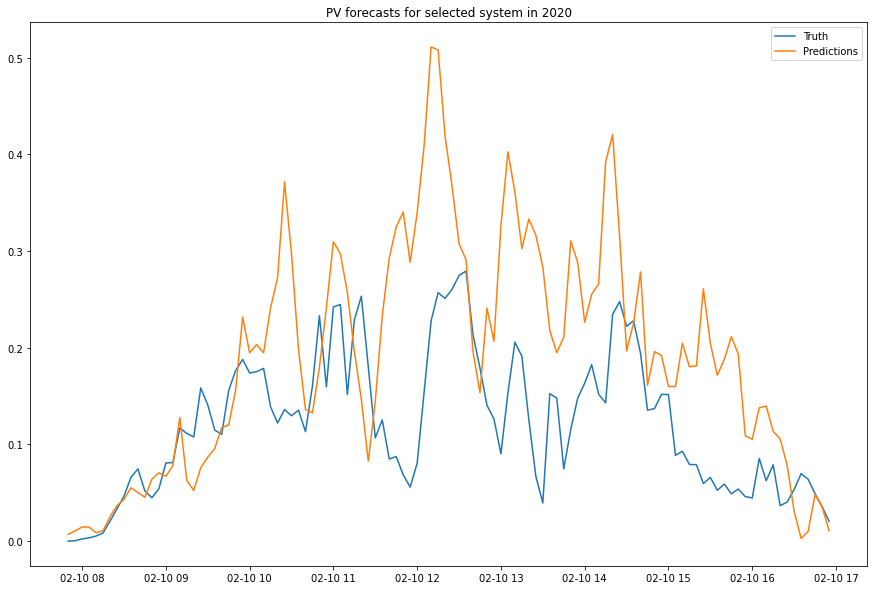

In [106]:
# Predicted PV yields

def print_between_obs(n):

    predictions = []
    truth = []
    dates = []

    for i in range(0,n):
        predictions.append(model.predict(test_sat_input[i].reshape(1,128,128,1), verbose=0)[0][0])
        truth.append(test_pv_input[i])
        dates.append(test_sat_times[i])

    plt.figure(figsize=(15,10))
    plt.plot(dates[:n], truth[:n], label='Truth')
    plt.plot(dates[:n], predictions[:n], label='Predictions')
    plt.legend()
    plt.title('PV forecasts for selected system in 2020');
    #plt.savefig('images/first_test_predictions.jpg')

print_between_obs(110)